In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 8)
# we use regex here to parse the output log files
import re

Populating the interactive namespace from numpy and matplotlib


In [5]:
# global variables
FOLDER_PREFIX="resnet_test_cpu_worker"

worker_num_interval = [2, 4, 8, 16, 32, 64]
# single node means, we have single worker node in cluster (ps+worker0)
single_node_time=11664.292
# signle machine means we only consider training on local machine, thus there is no communication cost
single_machine_time=10680.271

In [10]:
global_dict_saver = []
for num_w in worker_num_interval:
    # master is also include in this one, so the first worker should be the master
    time_stats_dict = {}
    for worker_index in range(num_w):
        if worker_index == 0:
            out_file=open(FOLDER_PREFIX+str(num_w)+'/out_master', 'rb')
        else:
            # for the case of 8 workers, we only consider master, worker0,...,worker6
            out_file=open(FOLDER_PREFIX+str(num_w)+'/out_worker_'+str(worker_index-1), 'rb')
        for line in out_file.readlines():
            line_string = line.rstrip('\n')
            search_sth = re.match('INFO:tensorflow:Worker(.*): (.*): step (.*), loss = (.*).* examples/sec; (.*) sec/batch.*', line_string)
            if search_sth:
                worker_index, cur_step, worker_time_cost = int(search_sth.group(1)), int(search_sth.group(3)), float(search_sth.group(5))
                if cur_step <= 300:
                    #print(worker_index, cur_step, worker_time_cost)
                    if cur_step not in time_stats_dict.keys():
                        time_stats_dict[cur_step]=[worker_time_cost]
                    else:
                        time_stats_dict[cur_step].append(worker_time_cost)
    global_dict_saver.append(time_stats_dict)

normal_speedup_vals = [1.0,]
ideal_speedup_vals = [1.0,]
normal_speedup_vals_local = [1.0,]
ideal_speedup_vals_local = [1.0,]
for dict_idx, stat_dict in enumerate(global_dict_saver):
    ideal_counter_ = 0
    full_counter_ = 0
    for k, v in stat_dict.iteritems():
        sorted_v = sorted(v)
        ideal_counter_+=sorted_v[0]
        full_counter_+=sorted_v[worker_num_interval[dict_idx]-1]
        #ideal_counter_+=min(v)
        #full_counter_+=max(v)
    normal_speedup_vals.append(float(single_node_time)/full_counter_)
    ideal_speedup_vals.append(float(single_node_time)/ideal_counter_)
    normal_speedup_vals_local.append(float(single_machine_time)/full_counter_)
    ideal_speedup_vals_local.append(float(single_machine_time)/ideal_counter_)
    print("Cluster set up with {} workers: ideal time: {} full time:{}".format(worker_num_interval[dict_idx], ideal_counter_, full_counter_))

Cluster set up with 2 workers: ideal time: 5447.961 full time:5801.12
Cluster set up with 4 workers: ideal time: 2727.785 full time:2916.948
Cluster set up with 8 workers: ideal time: 1427.88 full time:1533.708
Cluster set up with 16 workers: ideal time: 770.044 full time:828.257
Cluster set up with 32 workers: ideal time: 432.047 full time:469.484
Cluster set up with 64 workers: ideal time: 216.024 full time:459.304


In [11]:
print(normal_speedup_vals)
print
print(ideal_speedup_vals)
print
print
print(normal_speedup_vals_local)
print(ideal_speedup_vals_local)
workers_interval=[1, 2, 4, 8, 16, 32, 64]

[1.0, 2.010696555147972, 3.9988001157374033, 7.60528862078048, 14.082938025274752, 24.844919102674414, 25.395581140159877]

[1.0, 2.141038087460613, 4.276103871822744, 8.168958175757055, 15.147565593654399, 26.99773867195003, 53.995352368255354]


[1.0, 1.8410705174173267, 3.6614540266058873, 6.96369256729442, 12.894875624353302, 22.748956300960195, 23.253163482138177]
[1.0, 1.9604161997488618, 3.9153639308083314, 7.479809928005145, 13.869689264509573, 24.720160075177, 49.44020571788318]


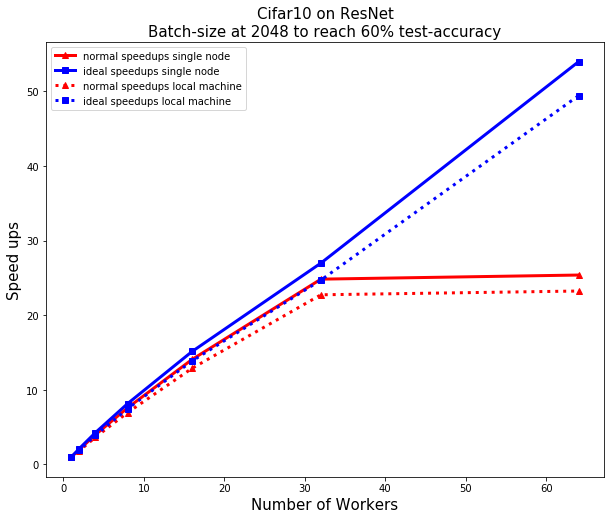

In [12]:
fig=plt.figure(1)
plt.plot(workers_interval, normal_speedup_vals, '-^r', linewidth=3.0, label="normal speedups single node")
plt.plot(workers_interval, ideal_speedup_vals, '-sb', linewidth=3.0, label='ideal speedups single node')
plt.plot(workers_interval, normal_speedup_vals_local, ':^r', linewidth=3.0, label="normal speedups local machine")
plt.plot(workers_interval, ideal_speedup_vals_local, ':sb', linewidth=3.0, label='ideal speedups local machine')
plt.title("Cifar10 on ResNet\nBatch-size at 2048 to reach 60% test-accuracy", multialignment='center',
         fontsize=15)
plt.xlabel("Number of Workers", fontsize=15)
plt.ylabel("Speed ups", fontsize=15)
plt.legend()
plt.savefig("straggler_ideal_speedup_comparison.jpg", dpi=600)
plt.show()